In [1]:
# Jupyter notebook Python code voor Autoencoder vraagstuk
# Auteur Kees van den Tempel, AI-labs BV, Tricht
# Versie 1.0
# 25-10-2022

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import datetime
from sklearn.preprocessing import OrdinalEncoder
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(2)
import random as rd
import tensorflow as tf
import pickle
#%matplotlib inline

# lees de bestanden met afbeeldingen met digits in
x_train = pd.read_csv("data/NN_Declaraties_autoencoder_train.csv", decimal=",", sep=";")
x_test = pd.read_csv("data/NN_Declaraties_autoencoder_test.csv", decimal=",", sep=";")

print("De x_train dataset bevat " + str(x_train.shape) + " records")
print("De x_train dataset bevat " + str(x_train.isnull().values.sum()) + " Null-waarden\n")
print("De x_test dataset bevat " + str(x_test.shape) + " records")
print("De x_test dataset bevat " + str(x_test.isnull().values.sum()) + " Null-waarden\n")

pd.options.mode.chained_assignment = None

De x_train dataset bevat (554280, 126) records
De x_train dataset bevat 0 Null-waarden

De x_test dataset bevat (61587, 126) records
De x_test dataset bevat 0 Null-waarden



In [2]:
# variabelen voor het optimaliseren van het algoritme
HyperparameterTuning = False
DevSet = 0


In [3]:
x_train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554280 entries, 0 to 554279
Data columns (total 126 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    Unnamed: 0                  int64  
 1    LevereenheidId_emb_1        int64  
 2    LevereenheidId_emb_2        int64  
 3    LevereenheidId_emb_3        int64  
 4    LevereenheidId_emb_4        int64  
 5    LevereenheidId_emb_5        int64  
 6    LevereenheidId_emb_6        int64  
 7    TeamId_emb_1                int64  
 8    TeamId_emb_2                int64  
 9    TeamId_emb_3                int64  
 10   TeamId_emb_4                int64  
 11   TeamId_emb_5                int64  
 12   TeamId_emb_6                int64  
 13   TeamId_emb_7                int64  
 14   TeamId_emb_8                int64  
 15   TeamId_emb_9                int64  
 16   TeamId_emb_10               int64  
 17   TeamId_emb_11               int64  
 18   TeamId_emb_12               int64  
 19   

In [4]:
# Execute onderstaande statement in de anaconda terminal
# python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
# Gaf foutmelding dat er bepaalde dlls niet gevonden konden worden
# Computer vaak herstarten na elke installatie
# Niet vindbare dll's in de map c:\windows\system32 kopieren gaf de oplossing

# Python version:  3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
# Tensorflow version:  2.10.0
# Keras version:  2.10.0
# Cudnn version:  64_8
# Cuda version:  64_112
# Eager mode:  True
# GPU is available
# Num GPUs: 1
# 1 Physical GPUs, 1 Logical GPUs

from __future__ import absolute_import, division, print_function, unicode_literals
import sys
import numpy as np
import tensorflow as tf
import tensorflow.python.platform.build_info as build
from tensorflow import keras

version = tf.__version__
executing_eagerly = tf.executing_eagerly()
available = tf.config.experimental.list_physical_devices("GPU")
physical_devices = tf.config.list_physical_devices('GPU')

print("Python version: ", sys.version)
print("Tensorflow version: ", version)
print("Keras version: ", keras.__version__)
#print("Cudnn version: ", build.build_info['cudnn_version'])
#print("Cuda version: ", build.build_info['cuda_version'])
print("Eager mode: ", executing_eagerly)
print("GPU is", "available" if available else "NOT AVAILABLE")
print("Num GPUs:", len(physical_devices))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Python version:  3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Tensorflow version:  2.11.0
Keras version:  2.11.0
Eager mode:  True
GPU is NOT AVAILABLE
Num GPUs: 0


In [5]:
# init deterministic seed
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   rd.seed(2)


In [6]:
pd.set_option('display.max_columns', None)
x_train.head(10)

,Unnamed: 0,LevereenheidId_emb_1,LevereenheidId_emb_2,LevereenheidId_emb_3,LevereenheidId_emb_4,LevereenheidId_emb_5,LevereenheidId_emb_6,TeamId_emb_1,TeamId_emb_2,TeamId_emb_3,TeamId_emb_4,TeamId_emb_5,TeamId_emb_6,TeamId_emb_7,TeamId_emb_8,TeamId_emb_9,TeamId_emb_10,TeamId_emb_11,TeamId_emb_12,TeamId_emb_13,TeamId_emb_14,TeamId_emb_15,TeamId_emb_16,GemeenteId_emb_1,GemeenteId_emb_2,GemeenteId_emb_3,GemeenteId_emb_4,GemeenteId_emb_5,GemeenteId_emb_6,GemeenteId_emb_7,GemeenteId_emb_8,GemeenteId_emb_9,GemeenteId_emb_10,GemeenteId_emb_11,GemeenteId_emb_12,GemeenteId_emb_13,GemeenteId_emb_14,GemeenteId_emb_15,GemeenteId_emb_16,GemeenteId_emb_17,GemeenteId_emb_18,GemeenteId_emb_19,BudgettypeId_emb_1,BudgettypeId_emb_2,BudgettypeId_emb_3,BudgettypeId_emb_4,BudgettypeId_emb_5,BudgettypeId_emb_6,BudgettypeId_emb_7,BudgettypeId_emb_8,BudgettypeId_emb_9,nAanbiederID_emb_1,nAanbiederID_emb_2,nAanbiederID_emb_3,nAanbiederID_emb_4,nAanbiederID_emb_5,nAanbiederID_emb_6,nAanbiederID_emb_7,nAanbiederID_emb_8,nAanbiederID_emb_9,nAanbiederID_emb_10,nAanbiederID_emb_11,nAanbiederID_emb_12,nAanbiederID_emb_13,nAanbiederID_emb_14,nAanbiederID_emb_15,nAanbiederID_emb_16,nAanbiederID_emb_17,nAanbiederID_emb_18,nAanbiederID_emb_19,nAanbiederID_emb_20,nAanbiederID_emb_21,nAanbiederID_emb_22,nAanbiederID_emb_23,nProductID_emb_1,nProductID_emb_2,nProductID_emb_3,nProductID_emb_4,nProductID_emb_5,nProductID_emb_6,nProductID_emb_7,nProductID_emb_8,nProductID_emb_9,nProductID_emb_10,nProductID_emb_11,nProductID_emb_12,nProductID_emb_13,nProductID_emb_14,nProductID_emb_15,nProductID_emb_16,nProductID_emb_17,nProductID_emb_18,nProductID_emb_19,nProductID_emb_20,nProductID_emb_21,nProductID_emb_22,nProductID_emb_23,nProductID_emb_24,KalenderJaar_emb_1,KalenderJaar_emb_2,KalenderJaar_emb_3,KalenderJaar_emb_4,KalenderJaar_emb_5,KalenderJaar_emb_6,KalenderJaar_emb_7,ContractStatusId_1,ContractStatusId_2,ContractStatusId_3,ContractId_1,EenhedenDeler_1,EenhedenDeler_2,DeclaratieId,Hoeveelheids,Periodenummer,GedeclareerdeTariefExclBtw,__ContractDuur,__MeanProductDecl,__AantalProductDecl,__MeanAanbiederDecl,__AantalAanbiederDecl,__DeclaratiePeriode,__MeanProductDeclduur,__StdDevClientDeclduur,__EerdereDeclaraties,__Volgnummer,GedeclareerdeKostenExclBtw
0,305254,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,2792293,0.000002,0.663123,0.000127,0.000431,0.028270,1.000000,0.016773,0.153137,0.000000,0.118938,0.086592,0.007564,0.019017,0.038335
1,190386,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,2350117,0.000003,0.992709,0.000070,0.008534,0.015654,0.056037,0.010476,0.247636,0.026291,0.067995,0.026038,0.013984,0.198098,0.038640
2,532373,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,3587963,0.000002,0.992709,0.000104,0.008707,0.017574,0.238165,0.008180,0.077638,0.000000,0.035839,0.027098,0.004980,0.041204,0.038705
3,39576,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1610490,0.000002,0.663123,0.000295,0.000948,0.004411,0.018278,0.014046,1.000000,0.000000,0.001838,0.018371,0.007431,0.064976,0.038316
4,434966,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,3197825,0.000002,0.239316,0.000138,0.009138,0.016132,0.057385,0.01

In [7]:
def DeleteVars(df):
    df.drop(['Unnamed: 0', 'DeclaratieId'], axis=1, inplace=True)

    volgnummers = [var for var in df.columns if '__' in var]
    print(volgnummers)
    df.drop(volgnummers, axis=1, inplace=True)

    #gemeenten = [var for var in df.columns if 'Gemeente' in var]
    #print(gemeenten)
    #df.drop(gemeenten, axis=1, inplace=True)

    #client = [var for var in df.columns if 'Client' in var]
    #print(client)
    #df.drop(client, axis=1, inplace=True)

    contract = [var for var in df.columns if 'ContractId' in var]
    print(contract)
    df.drop(contract, axis=1, inplace=True)

DID_train = x_train['DeclaratieId']
DID_test = x_test['DeclaratieId']
DeleteVars(x_train)
DeleteVars(x_test)

['__ContractDuur', '__MeanProductDecl', '__AantalProductDecl', '__MeanAanbiederDecl', '__AantalAanbiederDecl', '__DeclaratiePeriode', '__MeanProductDeclduur', '__StdDevClientDeclduur', '__EerdereDeclaraties', '__Volgnummer']
['ContractId_1']
['__ContractDuur', '__MeanProductDecl', '__AantalProductDecl', '__MeanAanbiederDecl', '__AantalAanbiederDecl', '__DeclaratiePeriode', '__MeanProductDeclduur', '__StdDevClientDeclduur', '__EerdereDeclaraties', '__Volgnummer']
['ContractId_1']


In [8]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554280 entries, 0 to 554279
Columns: 113 entries, LevereenheidId_emb_1 to GedeclareerdeKostenExclBtw
dtypes: float64(4), int64(109)
memory usage: 477.9 MB


In [9]:
# Splits de digits-dataset in een training- en een testset voor het machine learning model
# Eerst moet er een training en test set gemaakt worden om daarna allerlei bewerkingen en filters toe te passen
# om zo data leakage te voorkomen
   
print(str(type(x_train)) + ': x_train Shape:', x_train.shape)
print(str(type(x_test)) + ': x_test Shape:', x_test.shape)

<class 'pandas.core.frame.DataFrame'>: x_train Shape: (554280, 113)
<class 'pandas.core.frame.DataFrame'>: x_test Shape: (61587, 113)


In [10]:
#Schakel over van panda.dataframes naar numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)

print ("X-train (de kenmerken)" + str(x_train.shape))
print ("X-test (de test kenmerken)" + str(x_test.shape))

X-train (de kenmerken)(554280, 113)
X-test (de test kenmerken)(61587, 113)


In [11]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and dev-sets
if DevSet > 0:
    x_train, x_dev = train_test_split(x_train, test_size = DevSet, random_state = 42)
    print('Dimensie van de trainingset x_train:' + str (x_train.shape))
    print('Dimensie van de testset x_test:' + str(x_test.shape))
    print('Dimensie van de dev-set x_dev:' + str(x_dev.shape) + '\n')

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM, BatchNormalization, Conv2D, Input, MaxPool2D,Flatten, Permute, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import initializers, activations
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import CosineSimilarity
from tensorflow.keras import regularizers
from keras.losses import mean_squared_error
from keras.layers import LeakyReLU
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda

# define the learning rate change 
epochs = 500
learning_rate = 0.008 # initial learning rate
# decay_rate = learning_rate / epochs
decay_rate = 0.05
momentum = 0.8
Reg = 0.0
DropoutVal = 0

InnerLayer1 = x_train.shape[1]
InnerLayer2 = 60
InnerLayer3 = 30
InnerLayer4 = 0
InnerLayer5 = 0
InnerLayer6 = 0
InnerLayer7 = 0
LatentLayer = 12

bSize = 16384


In [23]:
# VAE NEURAAL NETWERK

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = None))
    
def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    return total_loss
    
def SelectOptimizer(i, lr):
    if i==1:
        tmp = Adam(learning_rate=lr, epsilon=1e-07)
    elif i==2:
        tmp = Nadam(learning_rate=lr, epsilon=1e-07)
    elif i==3:
        tmp = SGD(learning_rate=lr, momentum=0.8, nesterov=False)
    elif i==4:
        tmp = SGD(learning_rate=lr, momentum=0.8, nesterov=True)
    elif i==5:
        tmp = RMSprop(learning_rate=lr, momentum=0.8, epsilon=1e-07)
    return tmp

def VAEModel(activation, Param1, Param2, Param3, Param4, LatentParam, reg, DropoutVal, lr, OptIndex, Summary):
    initializer = initializers.GlorotUniform(seed=0)    #Xavier = default
    kregularizer=regularizers.L1(reg)
    bregularizer=l2(1e-4),
    aregularizer=l2(1e-5)
  
    # INPUT LAYER 1: default
    encoder_inputs = tf.keras.Input(shape=(x_train.shape[1],), name='encoder_input')

    # HIDDEN LAYER 1
    if reg>0:
         x = Dense(units=Param2, kernel_regularizer=l2(reg), kernel_initializer=initializer)(encoder_inputs)
    else:
         x = Dense(units=Param2, kernel_initializer=initializer)(encoder_inputs)
    x = Activation(activation)(x)
    if DropoutVal>0:
        x = Dropout(DropoutVal)(x)

    if Param3>0:
        if reg>0:
             x = Dense(units=Param3, kernel_regularizer=l2(reg), kernel_initializer=initializer)(x)
        else:
             x = Dense(units=Param3, kernel_initializer=initializer)(x)
        x = Activation(activation)(x)
        if DropoutVal>0:
            x = Dropout(DropoutVal)(x)

    if Param4>0:
        if reg>0:
             x = Dense(units=Param4, kernel_regularizer=l2(reg), kernel_initializer=initializer)(x)
        else:
             x = Dense(units=Param4, kernel_initializer=initializer)(x)
        x = Activation(activation)(x)
        if DropoutVal>0:
            x = Dropout(DropoutVal)(x)

    global z_mean
    z_mean = Dense(LatentParam, name='z_mean')(x)
    global z_log_var
    z_log_var = Dense(LatentParam, name='z_log_var')(x)
    
    # use the reparameterization trick and get the output from the sample() function
    z = Lambda(sample, output_shape=(LatentParam,), name='z')([z_mean, z_log_var])
    encoder = Model(encoder_inputs, z, name='encoder')
    if Summary==True: encoder.summary()


    latent_inputs = keras.Input(shape=(LatentParam,), name='z_sampling')
    x = latent_inputs
    if Param4>0:
        if reg>0:
             x = Dense(units=Param4, kernel_regularizer=l2(reg), kernel_initializer=initializer)(x)
        else:
             x = Dense(units=Param4, kernel_initializer=initializer)(x)
        x = Activation(activation)(x)
        if DropoutVal>0:
            x = Dropout(DropoutVal)(x)

    if Param3>0:
        if reg>0:
             x = Dense(units=Param3, kernel_regularizer=l2(reg), kernel_initializer=initializer)(x)
        else:
             x = Dense(units=Param3, kernel_initializer=initializer)(x)
        x = Activation(activation)(x)
        if DropoutVal>0:
            x = Dropout(DropoutVal)(x)
    
    if Param2>0:
        if reg>0:
             x = Dense(units=Param2, kernel_regularizer=l2(reg), kernel_initializer=initializer)(x)
        else:
             x = Dense(units=Param2, kernel_initializer=initializer)(x)
        x = Activation(activation)(x)
        if DropoutVal>0:
            x = Dropout(DropoutVal)(x)
    
    if reg>0:
         decoder_outputs = Dense(units=Param1, activation="linear", kernel_regularizer=l2(reg), kernel_initializer=initializer)(x)
    else:
         decoder_outputs = Dense(units=Param1, activation="linear", kernel_initializer=initializer)(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
    if Summary==True: decoder.summary()

    # full VAE model
    # https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5
    AEoutputs = decoder(encoder(encoder_inputs))
    vae_model = Model(encoder_inputs, AEoutputs, name='vae_mlp')
    opt = SelectOptimizer(OptIndex, lr)
    
    vae_model.compile(optimizer='Nadam', loss=vae_loss, metrics=['mse', 'mae', 'mape', 'accuracy'])
    if Summary==True: vae_model.summary()

    return vae_model


Text(0.5, 1.0, 'Learning rate als functie van epochs')

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Learning rate')]

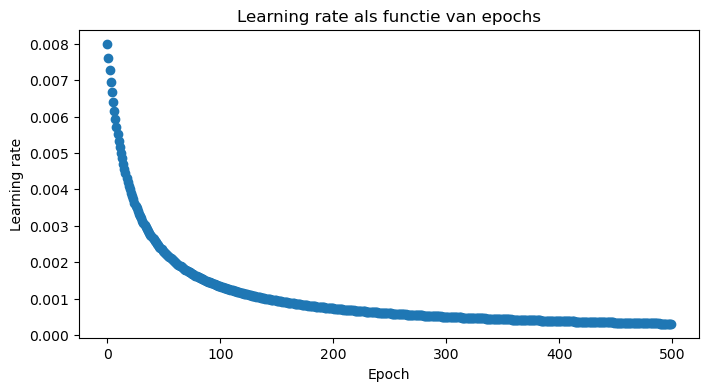

In [24]:
# Define the Required Callback Functions
from keras.callbacks import LearningRateScheduler

def exp_decay(epoch):
    #lrate = learning_rate * np.exp(-decay_rate*float(epoch))          #exponentieel
    lrate = learning_rate * 1/(1 + decay_rate * epoch)                #assymptoot naar 0
    #lrate = (((0.002-learning_rate)/epochs) * epoch) + learning_rate   #lineair naar 0
    return lrate

lr_rate = LearningRateScheduler(exp_decay)

class StopTraining(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # if(logs.get('accuracy')>0.99) or (logs.get('val_loss')<0.001):
        if (logs.get('val_loss')<0.001):
            print("\n99% val_accuracy bereikt, dus algorithme stopt met trainen")
            self.model.stop_training = True


# een grafiek maken van de learning rate\
x = list(range(0,epochs))
y = []
for i in x: y.append(exp_decay(i))
fig, axs = plt.subplots(figsize=(8, 4))
axs.scatter(x, y)
axs.set_title('Learning rate als functie van epochs')
axs.set(xlabel='Epoch', ylabel='Learning rate')
plt.show() 



Definieer AutoEncoder Neuraal netwerk
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 113)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 60)           6840        ['encoder_input[0][0]']          
                                                                                                  
 activation_4 (Activation)      (None, 60)           0           ['dense_5[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 30)           1830        ['activation_4[0][0]']           
                                                     

C:\Users\kvdte\anaconda3\lib\site-packages\keras\engine\training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


554280/554280 [==============================] - 4s 7us/sample - loss: 121372.3458 - mse: 0.0657 - mae: 0.1340 - mape: 68946264.0000 - accuracy: 0.0149 - val_loss: 82653.0342 - val_mse: 0.0469 - val_mae: 0.1123 - val_mape: 62101112.0000 - val_accuracy: 0.0059 - lr: 0.0080
Epoch 2/500
554280/554280 [==============================] - 3s 6us/sample - loss: 79501.9630 - mse: 0.0431 - mae: 0.1023 - mape: 55816080.0000 - accuracy: 0.0751 - val_loss: 66513.1254 - val_mse: 0.0377 - val_mae: 0.0911 - val_mape: 49938036.0000 - val_accuracy: 0.1123 - lr: 0.0076
Epoch 3/500
554280/554280 [==============================] - 3s 6us/sample - loss: 68636.5364 - mse: 0.0372 - mae: 0.0936 - mape: 52671256.0000 - accuracy: 0.1269 - val_loss: 60996.7665 - val_mse: 0.0346 - val_mae: 0.0870 - val_mape: 48769460.0000 - val_accuracy: 0.1138 - lr: 0.0073
Epoch 4/500
554280/554280 [==============================] - 3s 6us/sample - loss: 61477.7140 - mse: 0.0333 - mae: 0.0881 - mape: 51113996.0000 - accuracy: 0.1

Epoch 30/500
554280/554280 [==============================] - 3s 6us/sample - loss: 26554.7108 - mse: 0.0144 - mae: 0.0561 - mape: 37528512.0000 - accuracy: 0.1515 - val_loss: 23934.8515 - val_mse: 0.0135 - val_mae: 0.0525 - val_mape: 35047300.0000 - val_accuracy: 0.1686 - lr: 0.0033
Epoch 31/500
554280/554280 [==============================] - 3s 6us/sample - loss: 25989.6133 - mse: 0.0141 - mae: 0.0557 - mape: 37835196.0000 - accuracy: 0.1485 - val_loss: 24551.0915 - val_mse: 0.0139 - val_mae: 0.0548 - val_mape: 37123092.0000 - val_accuracy: 0.1284 - lr: 0.0032
Epoch 32/500
554280/554280 [==============================] - 3s 6us/sample - loss: 25627.9584 - mse: 0.0139 - mae: 0.0548 - mape: 36774076.0000 - accuracy: 0.1448 - val_loss: 23815.0922 - val_mse: 0.0135 - val_mae: 0.0533 - val_mape: 35639268.0000 - val_accuracy: 0.1770 - lr: 0.0031
Epoch 33/500
554280/554280 [==============================] - 3s 6us/sample - loss: 25494.4855 - mse: 0.0138 - mae: 0.0549 - mape: 37085392.0000 

Epoch 59/500
554280/554280 [==============================] - 3s 6us/sample - loss: 19187.3995 - mse: 0.0104 - mae: 0.0468 - mape: 32882202.0000 - accuracy: 0.1102 - val_loss: 17760.6889 - val_mse: 0.0100 - val_mae: 0.0444 - val_mape: 30947800.0000 - val_accuracy: 0.1328 - lr: 0.0021
Epoch 60/500
554280/554280 [==============================] - 3s 6us/sample - loss: 18900.6812 - mse: 0.0102 - mae: 0.0460 - mape: 32432546.0000 - accuracy: 0.1059 - val_loss: 17555.4234 - val_mse: 0.0099 - val_mae: 0.0436 - val_mape: 30584126.0000 - val_accuracy: 0.1151 - lr: 0.0020
Epoch 61/500
554280/554280 [==============================] - 3s 6us/sample - loss: 18796.4509 - mse: 0.0101 - mae: 0.0458 - mape: 32317688.0000 - accuracy: 0.1099 - val_loss: 17445.5684 - val_mse: 0.0099 - val_mae: 0.0433 - val_mape: 30353222.0000 - val_accuracy: 0.1188 - lr: 0.0020
Epoch 62/500
554280/554280 [==============================] - 3s 6us/sample - loss: 18637.4548 - mse: 0.0101 - mae: 0.0451 - mape: 31868478.0000 

Epoch 88/500
554280/554280 [==============================] - 4s 6us/sample - loss: 16370.2018 - mse: 0.0088 - mae: 0.0422 - mape: 30279464.0000 - accuracy: 0.1057 - val_loss: 15157.0612 - val_mse: 0.0086 - val_mae: 0.0396 - val_mape: 28239888.0000 - val_accuracy: 0.1221 - lr: 0.0015
Epoch 89/500
554280/554280 [==============================] - 4s 6us/sample - loss: 16052.5621 - mse: 0.0087 - mae: 0.0409 - mape: 29339310.0000 - accuracy: 0.1087 - val_loss: 15209.9448 - val_mse: 0.0086 - val_mae: 0.0403 - val_mape: 28788342.0000 - val_accuracy: 0.0950 - lr: 0.0015
Epoch 90/500
554280/554280 [==============================] - 4s 6us/sample - loss: 16064.1498 - mse: 0.0087 - mae: 0.0412 - mape: 29449960.0000 - accuracy: 0.1157 - val_loss: 15024.8370 - val_mse: 0.0085 - val_mae: 0.0397 - val_mape: 28304006.0000 - val_accuracy: 0.1056 - lr: 0.0015
Epoch 91/500
554280/554280 [==============================] - 4s 6us/sample - loss: 15808.6760 - mse: 0.0085 - mae: 0.0404 - mape: 28837202.0000 

Epoch 117/500
554280/554280 [==============================] - 3s 6us/sample - loss: 14080.6578 - mse: 0.0076 - mae: 0.0374 - mape: 26932080.0000 - accuracy: 0.1172 - val_loss: 13289.0478 - val_mse: 0.0075 - val_mae: 0.0367 - val_mape: 26462784.0000 - val_accuracy: 0.1277 - lr: 0.0012
Epoch 118/500
554280/554280 [==============================] - 3s 6us/sample - loss: 13968.3457 - mse: 0.0075 - mae: 0.0372 - mape: 26869528.0000 - accuracy: 0.1055 - val_loss: 13242.7028 - val_mse: 0.0075 - val_mae: 0.0367 - val_mape: 26490134.0000 - val_accuracy: 0.1068 - lr: 0.0012
Epoch 119/500
554280/554280 [==============================] - 3s 6us/sample - loss: 13841.9839 - mse: 0.0075 - mae: 0.0367 - mape: 26398300.0000 - accuracy: 0.1067 - val_loss: 13292.1410 - val_mse: 0.0075 - val_mae: 0.0370 - val_mape: 26602548.0000 - val_accuracy: 0.0877 - lr: 0.0012
Epoch 120/500
554280/554280 [==============================] - 3s 6us/sample - loss: 13938.8760 - mse: 0.0075 - mae: 0.0374 - mape: 26882690.0

Epoch 146/500
554280/554280 [==============================] - 3s 6us/sample - loss: 12849.6569 - mse: 0.0069 - mae: 0.0346 - mape: 25208424.0000 - accuracy: 0.1185 - val_loss: 12271.0348 - val_mse: 0.0069 - val_mae: 0.0345 - val_mape: 25147206.0000 - val_accuracy: 0.0880 - lr: 9.6970e-04
Epoch 147/500
554280/554280 [==============================] - 3s 6us/sample - loss: 12713.9073 - mse: 0.0068 - mae: 0.0340 - mape: 24643126.0000 - accuracy: 0.1161 - val_loss: 12083.1469 - val_mse: 0.0068 - val_mae: 0.0334 - val_mape: 24213332.0000 - val_accuracy: 0.1059 - lr: 9.6386e-04
Epoch 148/500
554280/554280 [==============================] - 3s 6us/sample - loss: 12689.2813 - mse: 0.0068 - mae: 0.0340 - mape: 24673194.0000 - accuracy: 0.1186 - val_loss: 12145.5718 - val_mse: 0.0068 - val_mae: 0.0339 - val_mape: 24555808.0000 - val_accuracy: 0.1157 - lr: 9.5808e-04
Epoch 149/500
554280/554280 [==============================] - 3s 6us/sample - loss: 12785.3753 - mse: 0.0069 - mae: 0.0346 - mape

554280/554280 [==============================] - 3s 6us/sample - loss: 11979.5343 - mse: 0.0064 - mae: 0.0329 - mape: 24020366.0000 - accuracy: 0.1147 - val_loss: 11363.9072 - val_mse: 0.0064 - val_mae: 0.0322 - val_mape: 23467390.0000 - val_accuracy: 0.1214 - lr: 8.2902e-04
Epoch 175/500
554280/554280 [==============================] - 3s 6us/sample - loss: 11920.5739 - mse: 0.0064 - mae: 0.0327 - mape: 23851156.0000 - accuracy: 0.1160 - val_loss: 11369.2152 - val_mse: 0.0064 - val_mae: 0.0325 - val_mape: 23659122.0000 - val_accuracy: 0.1333 - lr: 8.2474e-04
Epoch 176/500
554280/554280 [==============================] - 3s 6us/sample - loss: 11917.0029 - mse: 0.0064 - mae: 0.0329 - mape: 23873146.0000 - accuracy: 0.1172 - val_loss: 11351.2335 - val_mse: 0.0064 - val_mae: 0.0327 - val_mape: 23795918.0000 - val_accuracy: 0.1303 - lr: 8.2051e-04
Epoch 177/500
554280/554280 [==============================] - 3s 6us/sample - loss: 11912.8400 - mse: 0.0064 - mae: 0.0330 - mape: 24170130.000

554280/554280 [==============================] - 4s 6us/sample - loss: 11269.9387 - mse: 0.0061 - mae: 0.0309 - mape: 22440950.0000 - accuracy: 0.1115 - val_loss: 10750.0767 - val_mse: 0.0061 - val_mae: 0.0306 - val_mape: 22256892.0000 - val_accuracy: 0.1074 - lr: 7.2398e-04
Epoch 203/500
554280/554280 [==============================] - 4s 6us/sample - loss: 11287.9684 - mse: 0.0061 - mae: 0.0311 - mape: 22730064.0000 - accuracy: 0.1076 - val_loss: 10800.9533 - val_mse: 0.0061 - val_mae: 0.0312 - val_mape: 22765818.0000 - val_accuracy: 0.1000 - lr: 7.2072e-04
Epoch 204/500
554280/554280 [==============================] - 4s 7us/sample - loss: 11281.7149 - mse: 0.0061 - mae: 0.0312 - mape: 22794094.0000 - accuracy: 0.1056 - val_loss: 10742.3127 - val_mse: 0.0060 - val_mae: 0.0307 - val_mape: 22332146.0000 - val_accuracy: 0.0900 - lr: 7.1749e-04
Epoch 205/500
554280/554280 [==============================] - 4s 7us/sample - loss: 11237.1510 - mse: 0.0060 - mae: 0.0309 - mape: 22424370.000

554280/554280 [==============================] - 3s 6us/sample - loss: 10631.3775 - mse: 0.0057 - mae: 0.0295 - mape: 21464622.0000 - accuracy: 0.1066 - val_loss: 10143.7427 - val_mse: 0.0057 - val_mae: 0.0293 - val_mape: 21294544.0000 - val_accuracy: 0.1172 - lr: 6.4257e-04
Epoch 231/500
554280/554280 [==============================] - 3s 6us/sample - loss: 10619.8943 - mse: 0.0057 - mae: 0.0295 - mape: 21490362.0000 - accuracy: 0.1046 - val_loss: 10172.4547 - val_mse: 0.0057 - val_mae: 0.0296 - val_mape: 21561430.0000 - val_accuracy: 0.1086 - lr: 6.4000e-04
Epoch 232/500
554280/554280 [==============================] - 4s 7us/sample - loss: 10664.2135 - mse: 0.0057 - mae: 0.0299 - mape: 21838526.0000 - accuracy: 0.1010 - val_loss: 10136.5499 - val_mse: 0.0057 - val_mae: 0.0294 - val_mape: 21374630.0000 - val_accuracy: 0.0999 - lr: 6.3745e-04
Epoch 233/500
554280/554280 [==============================] - 3s 6us/sample - loss: 10596.9048 - mse: 0.0057 - mae: 0.0295 - mape: 21502632.000

554280/554280 [==============================] - 3s 6us/sample - loss: 10359.8006 - mse: 0.0056 - mae: 0.0288 - mape: 20960310.0000 - accuracy: 0.0994 - val_loss: 9891.6479 - val_mse: 0.0056 - val_mae: 0.0286 - val_mape: 20783578.0000 - val_accuracy: 0.1029 - lr: 5.7762e-04
Epoch 259/500
554280/554280 [==============================] - 3s 6us/sample - loss: 10359.8535 - mse: 0.0056 - mae: 0.0289 - mape: 20926844.0000 - accuracy: 0.1012 - val_loss: 9902.7245 - val_mse: 0.0056 - val_mae: 0.0286 - val_mape: 20778378.0000 - val_accuracy: 0.1086 - lr: 5.7554e-04
Epoch 260/500
554280/554280 [==============================] - 4s 6us/sample - loss: 10342.5466 - mse: 0.0056 - mae: 0.0287 - mape: 20866824.0000 - accuracy: 0.1047 - val_loss: 9889.6253 - val_mse: 0.0056 - val_mae: 0.0286 - val_mape: 20784016.0000 - val_accuracy: 0.1046 - lr: 5.7348e-04
Epoch 261/500
554280/554280 [==============================] - 3s 6us/sample - loss: 10340.5764 - mse: 0.0056 - mae: 0.0287 - mape: 20899920.0000 -

554280/554280 [==============================] - 4s 7us/sample - loss: 9798.8736 - mse: 0.0053 - mae: 0.0284 - mape: 20876726.0000 - accuracy: 0.1055 - val_loss: 9312.9662 - val_mse: 0.0052 - val_mae: 0.0280 - val_mape: 20499334.0000 - val_accuracy: 0.1067 - lr: 5.2459e-04
Epoch 287/500
554280/554280 [==============================] - 4s 7us/sample - loss: 9719.6648 - mse: 0.0052 - mae: 0.0279 - mape: 20449614.0000 - accuracy: 0.0997 - val_loss: 9286.6625 - val_mse: 0.0052 - val_mae: 0.0278 - val_mape: 20385462.0000 - val_accuracy: 0.1071 - lr: 5.2288e-04
Epoch 288/500
554280/554280 [==============================] - 4s 7us/sample - loss: 9719.0298 - mse: 0.0052 - mae: 0.0280 - mape: 20548232.0000 - accuracy: 0.1000 - val_loss: 9273.9190 - val_mse: 0.0052 - val_mae: 0.0278 - val_mape: 20378926.0000 - val_accuracy: 0.1069 - lr: 5.2117e-04
Epoch 289/500
554280/554280 [==============================] - 4s 7us/sample - loss: 9681.9558 - mse: 0.0052 - mae: 0.0278 - mape: 20371610.0000 - acc

554280/554280 [==============================] - 3s 6us/sample - loss: 9363.6407 - mse: 0.0050 - mae: 0.0269 - mape: 19724654.0000 - accuracy: 0.0986 - val_loss: 8941.8204 - val_mse: 0.0050 - val_mae: 0.0269 - val_mape: 19673310.0000 - val_accuracy: 0.1008 - lr: 4.8048e-04
Epoch 315/500
554280/554280 [==============================] - 3s 6us/sample - loss: 9348.4149 - mse: 0.0050 - mae: 0.0268 - mape: 19654544.0000 - accuracy: 0.0984 - val_loss: 8929.4694 - val_mse: 0.0050 - val_mae: 0.0268 - val_mape: 19638820.0000 - val_accuracy: 0.0980 - lr: 4.7904e-04
Epoch 316/500
554280/554280 [==============================] - 3s 6us/sample - loss: 9358.4054 - mse: 0.0050 - mae: 0.0269 - mape: 19747430.0000 - accuracy: 0.0949 - val_loss: 8933.6890 - val_mse: 0.0050 - val_mae: 0.0268 - val_mape: 19654412.0000 - val_accuracy: 0.1038 - lr: 4.7761e-04
Epoch 317/500
554280/554280 [==============================] - 3s 6us/sample - loss: 9357.8386 - mse: 0.0050 - mae: 0.0270 - mape: 19798674.0000 - acc

554280/554280 [==============================] - 3s 6us/sample - loss: 9211.2551 - mse: 0.0049 - mae: 0.0264 - mape: 19326198.0000 - accuracy: 0.0983 - val_loss: 8804.6908 - val_mse: 0.0049 - val_mae: 0.0264 - val_mape: 19309418.0000 - val_accuracy: 0.1018 - lr: 4.4321e-04
Epoch 343/500
554280/554280 [==============================] - 3s 6us/sample - loss: 9219.9209 - mse: 0.0049 - mae: 0.0265 - mape: 19403462.0000 - accuracy: 0.0987 - val_loss: 8802.8378 - val_mse: 0.0049 - val_mae: 0.0264 - val_mape: 19339254.0000 - val_accuracy: 0.0966 - lr: 4.4199e-04
Epoch 344/500
554280/554280 [==============================] - 3s 6us/sample - loss: 9214.9071 - mse: 0.0049 - mae: 0.0264 - mape: 19402268.0000 - accuracy: 0.0982 - val_loss: 8810.2060 - val_mse: 0.0049 - val_mae: 0.0264 - val_mape: 19379566.0000 - val_accuracy: 0.1045 - lr: 4.4077e-04
Epoch 345/500
554280/554280 [==============================] - 3s 6us/sample - loss: 9229.3212 - mse: 0.0050 - mae: 0.0265 - mape: 19469682.0000 - acc

554280/554280 [==============================] - 3s 6us/sample - loss: 9131.8944 - mse: 0.0049 - mae: 0.0261 - mape: 19156346.0000 - accuracy: 0.0972 - val_loss: 8728.1442 - val_mse: 0.0049 - val_mae: 0.0262 - val_mape: 19156470.0000 - val_accuracy: 0.1046 - lr: 4.1131e-04
Epoch 371/500
554280/554280 [==============================] - 3s 6us/sample - loss: 9133.2720 - mse: 0.0049 - mae: 0.0262 - mape: 19177108.0000 - accuracy: 0.1004 - val_loss: 8709.5033 - val_mse: 0.0049 - val_mae: 0.0259 - val_mape: 18997814.0000 - val_accuracy: 0.1079 - lr: 4.1026e-04
Epoch 372/500
554280/554280 [==============================] - 3s 6us/sample - loss: 9107.5253 - mse: 0.0049 - mae: 0.0260 - mape: 19046070.0000 - accuracy: 0.0988 - val_loss: 8697.1547 - val_mse: 0.0049 - val_mae: 0.0259 - val_mape: 18990634.0000 - val_accuracy: 0.1062 - lr: 4.0921e-04
Epoch 373/500
554280/554280 [==============================] - 3s 6us/sample - loss: 9103.2664 - mse: 0.0049 - mae: 0.0260 - mape: 19024822.0000 - acc

554280/554280 [==============================] - 3s 6us/sample - loss: 9044.7747 - mse: 0.0049 - mae: 0.0258 - mape: 18921124.0000 - accuracy: 0.1001 - val_loss: 8624.1551 - val_mse: 0.0048 - val_mae: 0.0256 - val_mape: 18777490.0000 - val_accuracy: 0.0945 - lr: 3.8369e-04
Epoch 399/500
554280/554280 [==============================] - 3s 6us/sample - loss: 9036.2765 - mse: 0.0048 - mae: 0.0257 - mape: 18845848.0000 - accuracy: 0.0994 - val_loss: 8629.4336 - val_mse: 0.0048 - val_mae: 0.0256 - val_mape: 18782050.0000 - val_accuracy: 0.0964 - lr: 3.8278e-04
Epoch 400/500
554280/554280 [==============================] - 3s 6us/sample - loss: 9026.6920 - mse: 0.0048 - mae: 0.0257 - mape: 18794908.0000 - accuracy: 0.0973 - val_loss: 8627.3025 - val_mse: 0.0048 - val_mae: 0.0256 - val_mape: 18792422.0000 - val_accuracy: 0.0990 - lr: 3.8186e-04
Epoch 401/500
554280/554280 [==============================] - 3s 6us/sample - loss: 9043.3833 - mse: 0.0048 - mae: 0.0258 - mape: 18907964.0000 - acc

554280/554280 [==============================] - 3s 6us/sample - loss: 8979.2553 - mse: 0.0048 - mae: 0.0256 - mape: 18751720.0000 - accuracy: 0.1024 - val_loss: 8565.8098 - val_mse: 0.0048 - val_mae: 0.0254 - val_mape: 18620944.0000 - val_accuracy: 0.1072 - lr: 3.5955e-04
Epoch 427/500
554280/554280 [==============================] - 3s 6us/sample - loss: 8958.0039 - mse: 0.0048 - mae: 0.0254 - mape: 18651204.0000 - accuracy: 0.1000 - val_loss: 8551.8924 - val_mse: 0.0048 - val_mae: 0.0253 - val_mape: 18571192.0000 - val_accuracy: 0.1049 - lr: 3.5874e-04
Epoch 428/500
554280/554280 [==============================] - 3s 6us/sample - loss: 8957.1521 - mse: 0.0048 - mae: 0.0254 - mape: 18627428.0000 - accuracy: 0.0997 - val_loss: 8559.6107 - val_mse: 0.0048 - val_mae: 0.0254 - val_mape: 18572826.0000 - val_accuracy: 0.1021 - lr: 3.5794e-04
Epoch 429/500
554280/554280 [==============================] - 3s 6us/sample - loss: 8954.6720 - mse: 0.0048 - mae: 0.0254 - mape: 18603050.0000 - acc

554280/554280 [==============================] - 3s 6us/sample - loss: 8902.9370 - mse: 0.0048 - mae: 0.0252 - mape: 18467868.0000 - accuracy: 0.1008 - val_loss: 8504.1542 - val_mse: 0.0048 - val_mae: 0.0251 - val_mape: 18416886.0000 - val_accuracy: 0.1018 - lr: 3.3827e-04
Epoch 455/500
554280/554280 [==============================] - 3s 6us/sample - loss: 8893.9095 - mse: 0.0048 - mae: 0.0251 - mape: 18418318.0000 - accuracy: 0.1007 - val_loss: 8500.3437 - val_mse: 0.0048 - val_mae: 0.0252 - val_mape: 18435508.0000 - val_accuracy: 0.1072 - lr: 3.3755e-04
Epoch 456/500
554280/554280 [==============================] - 3s 6us/sample - loss: 8904.7879 - mse: 0.0048 - mae: 0.0253 - mape: 18509850.0000 - accuracy: 0.1008 - val_loss: 8503.5847 - val_mse: 0.0048 - val_mae: 0.0252 - val_mape: 18431694.0000 - val_accuracy: 0.1074 - lr: 3.3684e-04
Epoch 457/500
554280/554280 [==============================] - 3s 6us/sample - loss: 8896.8781 - mse: 0.0048 - mae: 0.0252 - mape: 18453484.0000 - acc

554280/554280 [==============================] - 3s 6us/sample - loss: 8851.7154 - mse: 0.0047 - mae: 0.0250 - mape: 18331866.0000 - accuracy: 0.1021 - val_loss: 8467.7171 - val_mse: 0.0047 - val_mae: 0.0250 - val_mape: 18345064.0000 - val_accuracy: 0.1095 - lr: 3.1936e-04
Epoch 483/500
554280/554280 [==============================] - 3s 6us/sample - loss: 8865.9654 - mse: 0.0048 - mae: 0.0251 - mape: 18425188.0000 - accuracy: 0.1025 - val_loss: 8463.9741 - val_mse: 0.0047 - val_mae: 0.0251 - val_mape: 18381374.0000 - val_accuracy: 0.1081 - lr: 3.1873e-04
Epoch 484/500
554280/554280 [==============================] - 3s 6us/sample - loss: 8849.7589 - mse: 0.0047 - mae: 0.0250 - mape: 18336072.0000 - accuracy: 0.1038 - val_loss: 8457.9642 - val_mse: 0.0047 - val_mae: 0.0249 - val_mape: 18259626.0000 - val_accuracy: 0.1079 - lr: 3.1809e-04
Epoch 485/500
554280/554280 [==============================] - 4s 6us/sample - loss: 8845.9840 - mse: 0.0047 - mae: 0.0250 - mape: 18303988.0000 - acc

C:\Users\kvdte\anaconda3\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Text(0.5, 1.0, 'Loss')

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

Text(0.5, 1.0, 'Mse / Mae / Accuracy')

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Mse / Mae / Accuracy')]

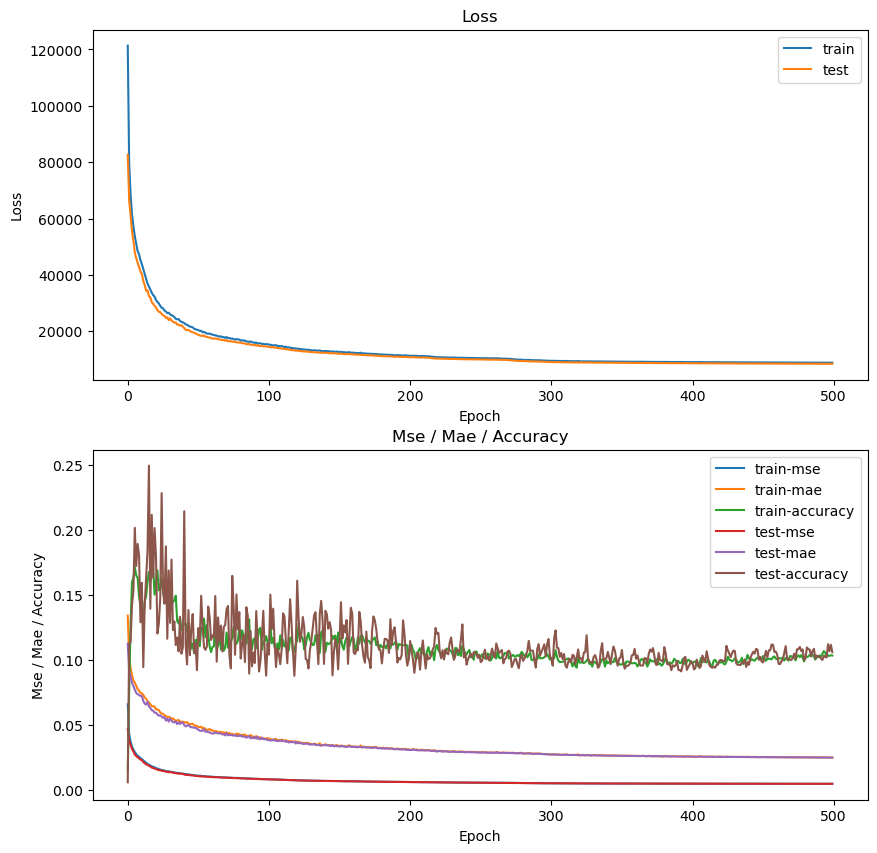

In [25]:
import matplotlib.pyplot as plt
from keras.callbacks import History
from sklearn.utils import compute_class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
from keras.layers import LeakyReLU
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

with tf.device("cpu:0"):

    # Autoencoder
    print("\nDefinieer AutoEncoder Neuraal netwerk")

    reset_random_seeds()
    if 1==2:   
        AEmodel = tf.keras.models.Sequential() 
        AEmodel.add(tf.keras.Input(shape=(InnerLayer1,)))
        if InnerLayer2>0:
            AEmodel.add(Dense(units=InnerLayer2, activation="relu", kernel_regularizer=l2(Reg)))
            if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        if InnerLayer3>0:
            AEmodel.add(Dense(units=InnerLayer3, activation="relu", kernel_regularizer=l2(Reg)))
            if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        if InnerLayer4>0:
            AEmodel.add(Dense(units=InnerLayer4, activation="relu", kernel_regularizer=l2(Reg)))
            if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        if InnerLayer5>0:
            AEmodel.add(Dense(units=InnerLayer5, activation="relu", kernel_regularizer=l2(Reg)))
            if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        if InnerLayer6>0:
            AEmodel.add(Dense(units=InnerLayer6, activation="relu", kernel_regularizer=l2(Reg)))
            if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        if InnerLayer7>0:
            AEmodel.add(Dense(units=InnerLayer7, activation="relu", kernel_regularizer=l2(Reg)))
            if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        AEmodel.add(Dense(units=LatentLayer, activation="relu", kernel_regularizer=l2(Reg)))
        if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        if InnerLayer7>0:
            AEmodel.add(Dense(units=InnerLayer7, activation="relu", kernel_regularizer=l2(Reg)))
            if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        if InnerLayer6>0:
            AEmodel.add(Dense(units=InnerLayer6, activation="relu", kernel_regularizer=l2(Reg)))
            if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        if InnerLayer5>0:
            AEmodel.add(Dense(units=InnerLayer5, activation="relu", kernel_regularizer=l2(Reg)))
            if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        if InnerLayer4>0:
            AEmodel.add(Dense(units=InnerLayer4, activation="relu", kernel_regularizer=l2(Reg)))
            if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        if InnerLayer3>0:
            AEmodel.add(Dense(units=InnerLayer3, activation="relu", kernel_regularizer=l2(Reg)))
            if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        if InnerLayer2>0:
            AEmodel.add(Dense(units=InnerLayer2, activation="relu", kernel_regularizer=l2(Reg)))
            if DropoutVal>0: AEmodel.add(Dropout(DropoutVal))
        AEmodel.add(Dense(units=InnerLayer1, activation="linear", kernel_regularizer=l2(Reg)))
        #opt = Nadam(learning_rate=0.01, epsilon=1e-07)
        AEmodel.compile(optimizer='Nadam', loss=root_mean_squared_error, metrics=['mse', 'mae', 'mape', 'accuracy'])    
        print(AEmodel.summary())
    else:
        AEmodel = VAEModel("relu", InnerLayer1, InnerLayer2, InnerLayer3, InnerLayer4, LatentLayer, 0, DropoutVal, 0.01, 2, True)

    # learning schedule callback
    callbacks_list = [lr_rate, StopTraining()]
    hist = AEmodel.fit(x_train,x_train, shuffle=True, epochs=epochs, batch_size=bSize, validation_data=(x_test, x_test), callbacks=callbacks_list, verbose=1)
    
    # plot the autoencoder
    # plot_model(AEmodel, 'data/autoencoder.png', show_shapes=True)    
    x_pred = AEmodel.predict(x_test)

    # plot loss and accuracy during training
    fig, axs = plt.subplots(2,1,figsize=(10, 10))
    axs[0].plot(hist.history['loss'], label='train')
    axs[0].plot(hist.history['val_loss'], label='test')
    axs[0].set_title('Loss')
    axs[0].set(xlabel='Epoch', ylabel='Loss')
    axs[0].legend()

    axs[1].plot(hist.history['mse'], label='train-mse')
    axs[1].plot(hist.history['mae'], label='train-mae')
    axs[1].plot(hist.history['accuracy'], label='train-accuracy')
    axs[1].plot(hist.history['val_mse'], label='test-mse')
    axs[1].plot(hist.history['val_mae'], label='test-mae')
    axs[1].plot(hist.history['val_accuracy'], label='test-accuracy')
    axs[1].set_title('Mse / Mae / Accuracy')
    axs[1].set(xlabel='Epoch', ylabel='Mse / Mae / Accuracy')
    axs[1].legend()
    plt.show() 


In [27]:
# Epoch 500/500
# 554280/554280 [==============================] - 3s 6us/sample - loss: 937.3878 - mse: 5.0352e-04 - 
# mae: 0.0069 - mape: 5124698.0000 - accuracy: 0.2116 - val_loss: 888.2819 - val_mse: 4.9728e-04 - 
# val_mae: 0.0068 - val_mape: 5060099.0000 - val_accuracy: 0.2366 - lr: 3.0829e-04
                                            
import scipy
from sklearn.metrics import r2_score

print(list(hist.history['loss'])[-1])
print(list(hist.history['val_loss'])[-1])
print(list(hist.history['lr'])[-1])
print("\n")

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(1,10), list(hist.history['loss'])[-9:])
print("Slope: " + str(slope))

# Calculate Eucledian Distance
m = np.sqrt(np.sum(np.square(np.subtract(x_pred, x_test)), axis=1))
count = np.count_nonzero(m < 1)
print("Testrecords: " + str(len(x_test)) + " : " + str(count))

r2 = r2_score(x_test, x_pred)
print("R2 = " + str(r2))

8818.847208773375
8425.298336767562
0.00030828518


Slope: -2.739785155310407
Testrecords: 61587 : 49924
R2 = 0.7146706884393


In [28]:
# Slope: -0.0002583066001534462
# 61587 : 60183
# 0.8023598236234031

In [29]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

DF = pd.concat([DID_test, pd.DataFrame(m)], axis=1)
# DF.head()
print(DF[DF[0]>1.20]['DeclaratieId'])

36       1253273
39       2107999
41       2942747
56       3997413
67       3714721
          ...   
61546    1564288
61555    2420482
61572    1528096
61574    1608176
61584    1530846
Name: DeclaratieId, Length: 5663, dtype: int64


(array([2.4706e+04, 1.5119e+04, 1.4606e+04, 5.7960e+03, 1.2600e+03,
        9.7000e+01, 1.0000e+00, 2.0000e+00]),
 array([0.06656564, 0.41844322, 0.7703208 , 1.12219837, 1.47407595,
        1.82595352, 2.1778311 , 2.52970867, 2.88158625]),
 <BarContainer object of 8 artists>)

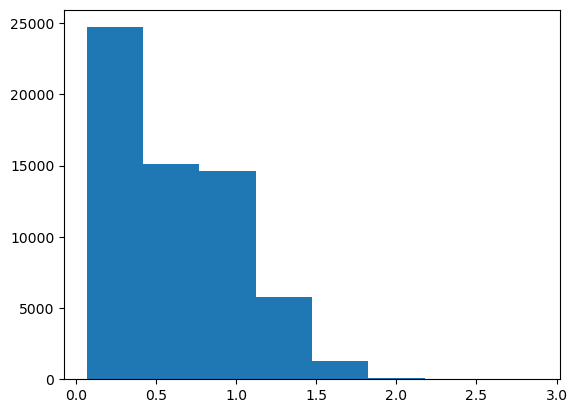

In [30]:
NoBins = 8
pdm=pd.DataFrame(m)
plt.hist(pdm[pdm[0]<NoBins], bins=NoBins)
plt.show()

In [20]:
# Pas het neurale netwerk nogmaals toe, maar nu door de training en test data 
# steeds te splitsen mbv kFold
import os
import scipy
from sklearn.model_selection import KFold
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import r2_score

# https://stackoverflow.com/questions/39758094/clearing-tensorflow-gpu-memory-after-model-execution
from numba import cuda 
#InteractiveSession.close()

TF_CONFIG = ConfigProto()
TF_CONFIG.gpu_options.per_process_gpu_memory_fraction = 0.333
# TF_CONFIG = ConfigProto(gpu_options=GPUOptions(per_process_gpu_memory_fraction=0.1),allow_soft_placement=True)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
#InteractiveSession.close(_self)
# df = x_train[["ClientId", "Periodenummer", "GedeclareerdeKostenExclBtw", "GemeenteId", "nProductID", "nAanbiederID", "EerdereDeclaraties"]]


if HyperparameterTuning == True:
    with tf.device("cpu:0"):
        print("Dimensie van de X-training: " + str(np.shape(x_train)) + " "+ str(type(x_train)))
        print("Dimensie van de X-test: " + str(np.shape(x_test)) + " "+ str(type(x_test)))

        print("\nOptimalisatie beste Neurale Netwerk: aantal nodes per layer en met kFold)")
        NNscores=[]
        ParamScores=[]
        ParamScores.append(["Cnt", "LatentLay", "Dropout", "Param2", "Param3", "lRate", "DevSet", "Reg", "Opt", "bSize", "Epochs", "Count_train", "Count_test", "R2_train", "R2_test", "x_train", "x_test", "vmse", "vmsetest", "vmae", "vmaetest", "vacc", "vacctest", "vloss", "vlosstest", "vmape", "vmapetest", "Slope"])
        cnt = 0
        Dout = DropoutVal
        DevSet = 0
        Opt = 2
        if DevSet>0:
            X_train, X_dev = train_test_split(x_train, test_size = DevSet, random_state = 42)
        else:
            X_train = x_train.copy()
        
        for LearnRate in range(0, 20, 20):
            #print("Optimalisatie Param 1; Learning Rate: " + str(float(LearnRate/100000)))
            lRate = LearnRate/100000
            # for dSet in range(1, 2, 1):
                # DevSet = dSet/40
                # X_train, X_dev = train_test_split(x_train, test_size = DevSet, random_state = 42)
            for DropoutV in range(0, 1, 1):
                Dout = float(DropoutV/10)
                print("Dropout: " + str(Dout))
                for iReg in range(0,1,1):
                    Reg = iReg/100000
                    for Param3 in range(0,71,35):
                        InnerLayer3 = Param3
                        for Param2 in range(60,81,3):
                            bSize = 16*1024
                            InnerLayer2 = Param2
                            for LatentLay in range(10,15,2):
                                #InteractiveSession.close(_self)
                                sess = InteractiveSession(config=TF_CONFIG)
                                reset_random_seeds()

                                # def VAEModel(Activation, Param1, Param2, Param3, Param4, LatentParam, Reg, DropoutVal, lr, Optimizer):
                                AEmodel = VAEModel("relu", InnerLayer1, InnerLayer2, InnerLayer3, InnerLayer4, LatentLay, Reg, Dout, lRate, Opt, False)
                                cnt=cnt+1
                                NNscores.clear()
                                print("\nParameters bij onderstaande resultaten\nLearningRate:" + str(lRate) + "  Dropout:" + str(Dout) + "  Param2:" + str(Param2) + "  Param3:" + str(Param3) + "  LatentLayer:" + str(LatentLay) + "  DevSet:" + str(DevSet) + "  Reg:" + str(Reg) + "  Opt:" + str(Opt) + "  Batchsize:" + str(bSize) + "  Epochs:" + str(epochs))

                                hist = AEmodel.fit(X_train, X_train, batch_size=bSize, epochs=epochs, validation_data=(x_test, x_test), callbacks=callbacks_list, verbose=0)

                                vmse = list(hist.history['mse'])[-1]
                                vmsetest = list(hist.history['val_mse'])[-1]
                                vmae = list(hist.history['mae'])[-1]
                                vmaetest = list(hist.history['val_mae'])[-1]
                                vacc = list(hist.history['accuracy'])[-1]
                                vacctest = list(hist.history['val_accuracy'])[-1]
                                vloss = list(hist.history['loss'])[-1]
                                vlosstest = list(hist.history['val_loss'])[-1]
                                vmape = list(hist.history['mape'])[-1]
                                vmapetest = list(hist.history['val_mape'])[-1]
                                vlr = list(hist.history['lr'])[-1]

                                xtrain_pred = AEmodel.predict(X_train)
                                xtest_pred = AEmodel.predict(x_test)

                                # Bepaal de R2 score op de training set en bepaals hoeveel records een EUCL DIST < 1 hebben
                                m_train = np.sqrt(np.sum(np.square(np.subtract(xtrain_pred, X_train)), axis=1))
                                count_train = np.count_nonzero(m_train < 1)/X_train.shape[0]
                                r2_train = r2_score(X_train, xtrain_pred)
                                
                                # Bepaal de R2 score op de test set en bepaals hoeveel records een EUCL DIST < 1 hebben
                                m_test = np.sqrt(np.sum(np.square(np.subtract(xtest_pred, x_test)), axis=1))
                                count_test = np.count_nonzero(m_test < 1)/x_test.shape[0]
                                r2_test = r2_score(x_test, xtest_pred)
                                
                                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(1,10), list(hist.history['loss'])[-9:])

                                print ("Loss: " + str(vloss) + "  Loss test-set: " + str(vlosstest))
                                ParamScores.append([cnt, LatentLay, Dout, Param2, Param3, vlr, DevSet, Reg, Opt, bSize, epochs, count_train, count_test, r2_train, r2_test, X_train.shape, x_test.shape, vmse, vmsetest, vmae, vmaetest, vacc, vacctest, vloss, vlosstest, vmape, vmapetest, slope])

                                #device = cuda.get_current_device()
                                #device.reset()
                                sess.close()
                                #cuda.select_device(0)
                                #cuda.close()

    fig, axs = plt.subplots(2,1,figsize=(10, 5))
    axs[0].plot(hist.history['loss'], label='train')
    axs[0].plot(hist.history['val_loss'], label='test')
    axs[0].set_title('Loss')
    axs[0].set(xlabel='epoch', ylabel='loss')
    axs[0].legend()

    axs[1].plot(hist.history['mse'], label='train-mse')
    axs[1].plot(hist.history['mae'], label='train-mae')
    axs[1].plot(hist.history['accuracy'], label='train-accuracy')
    axs[1].plot(hist.history['val_mse'], label='test-mse')
    axs[1].plot(hist.history['val_mae'], label='test-mae')
    axs[1].plot(hist.history['val_accuracy'], label='test-accuracy')
    axs[1].set_title('Mse / Mae / Accuracy')
    axs[1].set(xlabel='Epoch', ylabel='Mse / Mae / Accuracy')
    axs[1].legend()
    plt.show() 


In [21]:
if HyperparameterTuning == True:
    df = pd.DataFrame(ParamScores)
    writer = pd.ExcelWriter('test_3l2.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name='testresults', index=False)
    writer.save()
    writer.close()
